<a href="https://colab.research.google.com/github/Maria-Data-Analyst/Amazon_Sales/blob/Consultas-Query/analisis_exploratorio_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vaderSentiment textblob nltk  nltk nltk wordcloud google-cloud-bigquery pandas openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
##CODIGO PARA AUTENTICARSE CON GOOGLE
from google.colab import auth
auth.authenticate_user()

## CODIGO PARA VINCULARSE A BIGQUERY
from google.cloud import bigquery

# Configurar el cliente de BigQuery
client = bigquery.Client(project='amazon4-4')
# Definir la consulta para la vista
query = """
SELECT *
FROM `amazon4-4.dataset.consolidado_1`
"""
# Ejecutar la consulta
query_job = client.query(query)
results = query_job.result()

# Convertir los resultados a un DataFrame de pandas
df_consolidado = results.to_dataframe()

array([[<Axes: title={'center': 'discounted_price'}>,
        <Axes: title={'center': 'actual_price'}>],
       [<Axes: title={'center': 'discount_percentage'}>,
        <Axes: title={'center': 'rating'}>],
       [<Axes: title={'center': 'rating_count'}>, <Axes: >]], dtype=object)

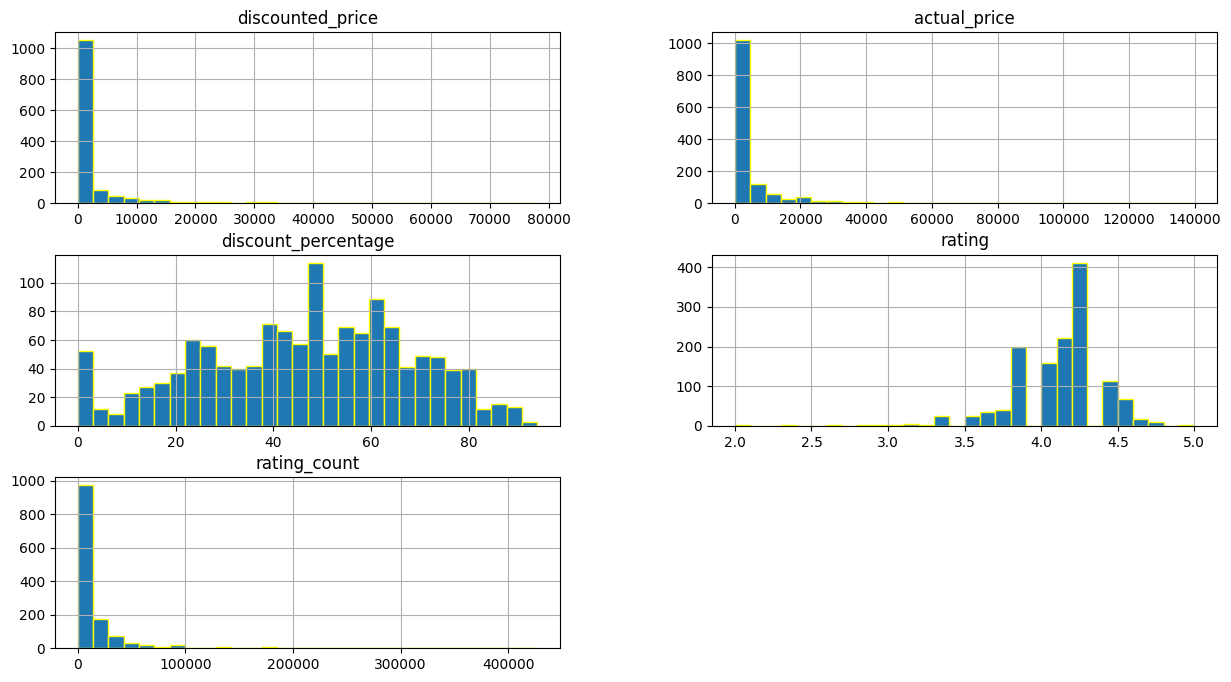

In [ ]:
df_consolidado.hist(figsize=(15,8),bins =30, edgecolor="yellow")

In [ ]:
df_consolidado.describe()

,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1339.00,1339.00,1339.00,1339.00,1339.00
mean,3283.53,5624.27,46.59,4.09,17639.65
std,7177.52,11213.94,21.54,0.30,42286.87
min,39.00,39.00,0.00,2.00,2.00
25%,349.00,899.00,31.00,3.90,1094.50
50%,889.00,1750.00,49.00,4.10,4716.00
75%,2158.50,4495.00,62.00,4.30,15828.50
max,77990.00,139900.00,94.00,5.00,426973.00


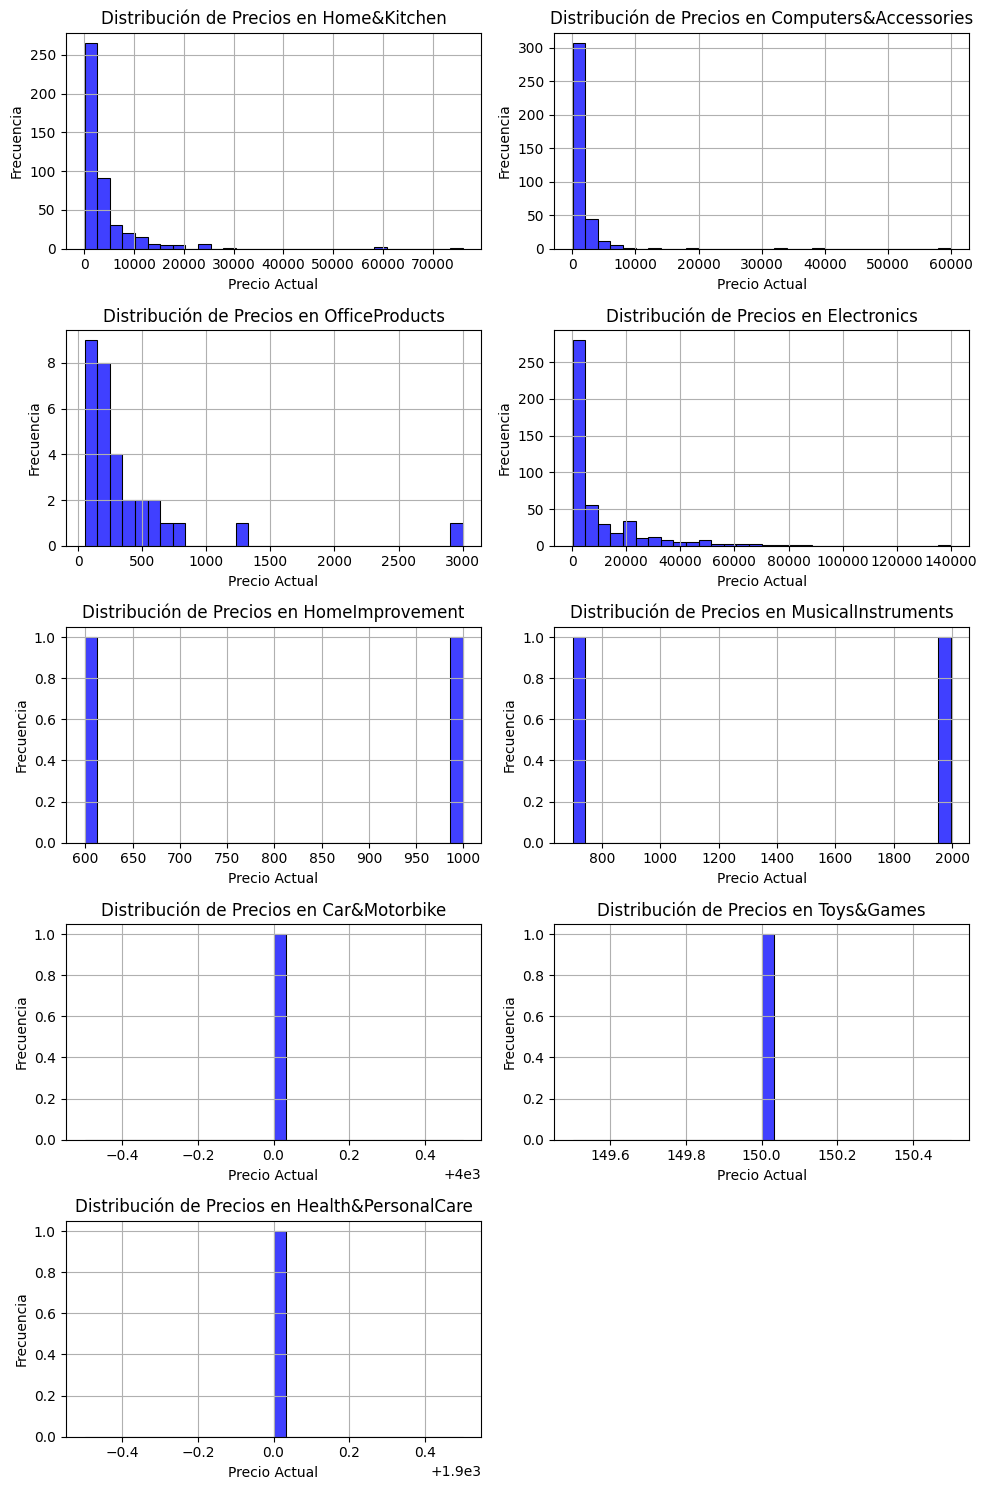

In [ ]:

# Crear una lista de categorías
categorias = df_consolidado['main_category'].unique()

# Determinar el número de categorías
num_categorias = len(categorias)

# Calcular el número de filas y columnas para los subgráficos
num_filas = int(np.ceil(num_categorias / 2))  # Número de filas necesario
num_columnas = 2  # Número de columnas fijo

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 3 * num_filas))

# Iterar sobre cada categoría
for i, categoria in enumerate(categorias, 1):
    # Filtrar los datos para la categoría actual
    df_categoria = df_consolidado[df_consolidado['main_category'] == categoria]

    # Crear el histograma
    plt.subplot(num_filas, num_columnas, i)
    sns.histplot(df_categoria['actual_price'], bins=30, kde=False, color='blue')
    plt.title(f'Distribución de Precios en {categoria}')
    plt.xlabel('Precio Actual')
    plt.ylabel('Frecuencia')
    plt.grid(True)

# Ajustar el layout
plt.tight_layout()
plt.show()



In [ ]:
# Definir los límites de precios por categoría
limites_precios = {
    'Electronics': 80000,
    'Home&Kitchen': 20000,
    'Computers&Accessories': 10000,
    'OfficeProducts': 1000
}

# Aplicar el filtro y calcular estadísticas descriptivas para cada categoría
estadisticas = {}
for categoria, limite_precio in limites_precios.items():
    # Filtrar los datos para la categoría y aplicar el límite de precio
    df_filtrado = df_consolidado[(df_consolidado['main_category'] == categoria) & (df_consolidado['actual_price'] <= limite_precio)]

    # Calcular estadísticas descriptivas
    estadisticas[categoria] = {
        'conteo_productos_unicos': df_filtrado['product_id'].nunique(),
        'max_price': df_filtrado['actual_price'].max(),
        'min_price': df_filtrado['actual_price'].min(),
        'promedio_price': df_filtrado['actual_price'].mean(),
        'mediana_price': df_filtrado['actual_price'].median(),
        'desviacion_estandar_price': df_filtrado['actual_price'].std()
    }

# Crear un DataFrame a partir del diccionario de estadísticas
estadisticas_df = pd.DataFrame(estadisticas).T

# Ordenar el DataFrame por el conteo de productos únicos en orden descendente
estadisticas_df = estadisticas_df.sort_values(by='conteo_productos_unicos', ascending=False)

# Configurar pandas para mostrar todas las filas y columnas sin truncamiento
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)  # Ajustar el ancho del display
pd.set_option('display.float_format', '{:.2f}'.format)  # Formato de punto flotante

# Mostrar el resumen
print(estadisticas_df)


                       conteo_productos_unicos  max_price  min_price  promedio_price  mediana_price  desviacion_estandar_price
Electronics                             479.00   79990.00     171.00         9867.58        2999.00                   14514.65
Home&Kitchen                            436.00   19990.00      79.00         3370.11        1999.00                    3597.91
Computers&Accessories                   368.00    9625.00      39.00         1445.40         999.00                    1301.47
OfficeProducts                           29.00     800.00      50.00          276.52         180.00                     204.35


In [ ]:
# Contar el número de productos únicos por categoría
conteo_productos_unicos = df_consolidado.groupby('main_category')['product_id'].nunique()

# Calcular estadísticas descriptivas para cada categoría usando actual_price
estadisticas = df_consolidado.groupby('main_category').agg(
    conteo_productos_unicos=('product_id', 'nunique'),
    max_price=('actual_price', 'max'),
    min_price=('actual_price', 'min'),
    promedio_price=('actual_price', 'mean'),
    mediana_price=('actual_price', 'median'),
    desviacion_estandar_price=('actual_price', 'std')
)

# Ordenar el DataFrame por el conteo de productos únicos en orden descendente
estadisticas = estadisticas.sort_values(by='conteo_productos_unicos', ascending=False)

# Configurar pandas para mostrar todas las filas y columnas sin truncamiento
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', 1000)  # Ajustar el ancho del display
pd.set_option('display.float_format', '{:.2f}'.format)  # Formato de punto flotante

# Mostrar el resumen
print(estadisticas)

                       conteo_productos_unicos  max_price  min_price  promedio_price  mediana_price  desviacion_estandar_price
main_category                                                                                                                 
Electronics                                481  139900.00     171.00        10294.12        2999.00                   16018.77
Home&Kitchen                               447   75990.00      79.00         4165.79        2000.00                    6808.87
Computers&Accessories                      373   59890.00      39.00         1862.35         999.00                    4245.73
OfficeProducts                              31    2999.00      50.00          397.19         210.00                     552.78
HomeImprovement                              2     999.00     599.00          799.00         799.00                     282.84
MusicalInstruments                           2    1995.00     699.00         1347.00        1347.00            

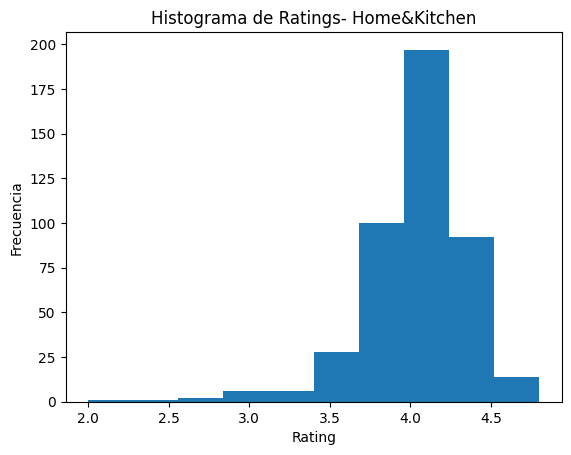

In [ ]:
df_electronics = df_consolidado[df_consolidado["main_category"]=="Home&Kitchen"]

plt.hist(df_electronics["rating"], bins=10)

#añadir título y etiquetas
plt.title("Histograma de Ratings- Home&Kitchen")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")

#mostrar el histograma
plt.show()

In [ ]:
# Filtrar categorías con más de 5 productos
conteo_productos = df_consolidado['main_category'].value_counts()
categorias_filtradas = conteo_productos[conteo_productos > 5].index

# Filtrar el DataFrame para que solo incluya las categorías con más de 5 productos
df_filtrado = df_consolidado[df_consolidado['main_category'].isin(categorias_filtradas)]

# Crear el gráfico de caja (box plot) con las categorías filtradas
fig = px.box(df_filtrado,
             x="main_category",
             y="rating",  # La variable de la cual deseas visualizar la distribución
             title="Distribución de Ratings por Categoría",
             labels={
                 "main_category": "Categoría Principal",
                 "rating": "Rating"
             })

# Mejorar el diseño del gráfico
fig.update_layout(
    xaxis_title="Categoría Principal",
    yaxis_title="Rating",
    xaxis={'categoryorder':'total descending'},  # Ordena las categorías
    template="plotly_white"
)

fig.show()



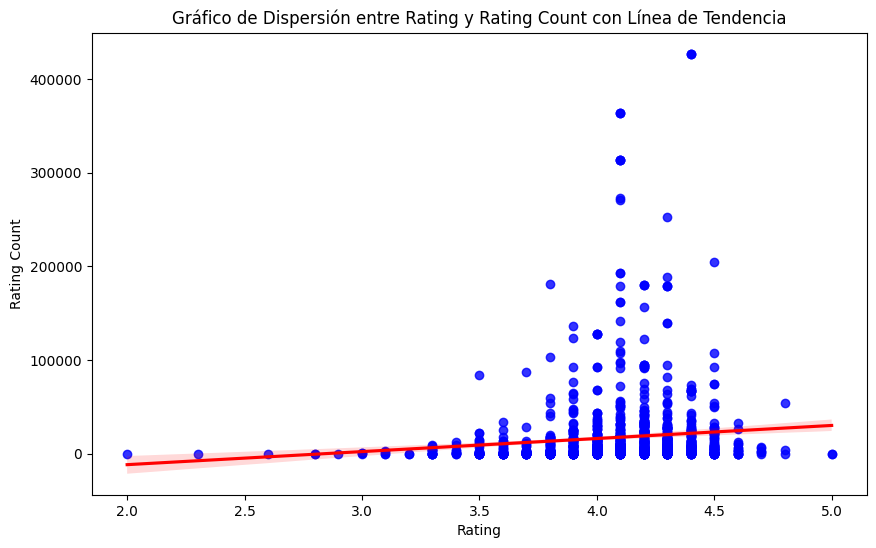

In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión con la línea de tendencia
sns.regplot(x="rating", y="rating_count", data=df_consolidado, scatter_kws={"color": "blue"}, line_kws={'color': 'red'})

# Añadir etiquetas y título
plt.xlabel('Rating')
plt.ylabel('Rating Count')
plt.title('Gráfico de Dispersión entre Rating y Rating Count con Línea de Tendencia')

# Mostrar el gráfico
plt.show()

In [ ]:
fig = px.box(df_consolidado, x= "main_category", y="discounted_price", points="all")
fig.show()

In [ ]:
fig = px.box(df_consolidado, x= "main_category", y="actual_price", points="all")
fig.show()

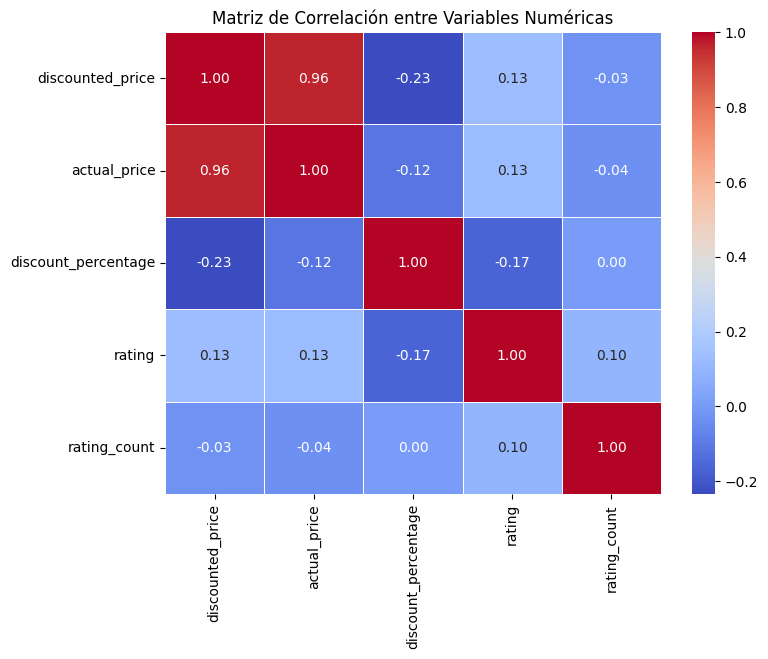

In [ ]:
df_numericas = df_consolidado.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
matriz_correlacion = df_numericas.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crear el mapa de calor de la matriz de correlación
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación entre Variables Numéricas')

# Mostrar el gráfico
plt.show()


In [ ]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            1339 non-null   object 
 1   product_name          1339 non-null   object 
 2   category              1339 non-null   object 
 3   main_category         1339 non-null   object 
 4   second_category       1339 non-null   object 
 5   other_categories      1331 non-null   object 
 6   discounted_price      1339 non-null   float64
 7   actual_price          1339 non-null   float64
 8   discount_percentage   1339 non-null   float64
 9   rating                1339 non-null   float64
 10  rating_count          1339 non-null   float64
 11  link_corregido_final  880 non-null    object 
 12  imagen_unica          879 non-null    object 
 13  img_general           879 non-null    object 
 14  product_link          880 non-null    object 
dtypes: float64(5), object

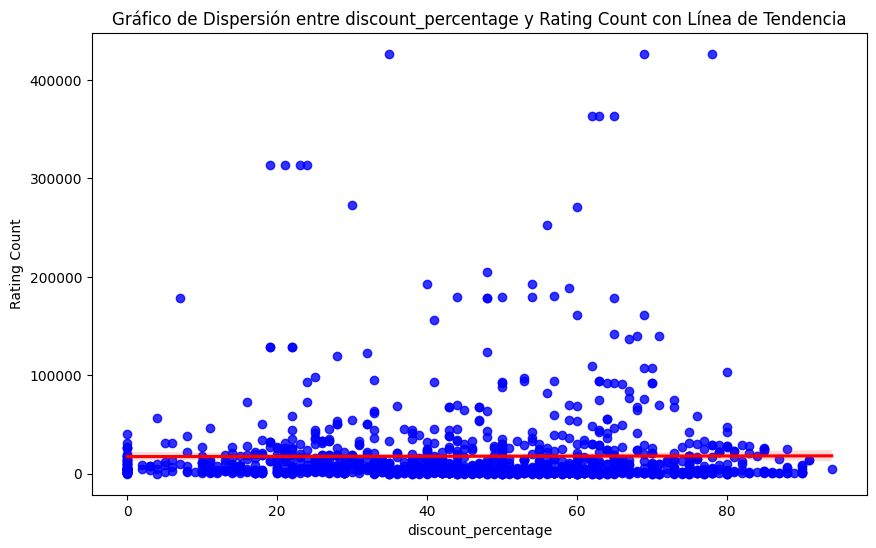

La correlación de Pearson entre 'rating_count' y 'discounted_percentage' es: 0.004136821251956393


In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión con la línea de tendencia
sns.regplot(x="discount_percentage", y="rating_count", data=df_consolidado, scatter_kws={"color": "blue"}, line_kws={'color': 'red'})

# Añadir etiquetas y título
plt.xlabel('discount_percentage')
plt.ylabel('Rating Count')
plt.title('Gráfico de Dispersión entre discount_percentage y Rating Count con Línea de Tendencia')

# Mostrar el gráfico
plt.show()
# Calcular la correlación de Pearson entre 'rating' y 'discounted_percentage'
correlacion_pearson = df_consolidado['rating_count'].corr(df_consolidado['discount_percentage'], method='pearson')

# Mostrar el resultado
print(f"La correlación de Pearson entre 'rating_count' y 'discounted_percentage' es: {correlacion_pearson}")

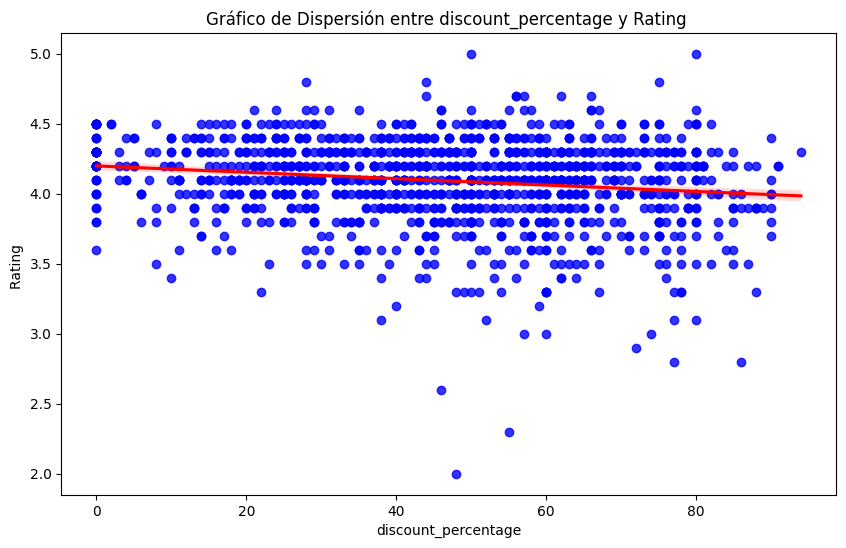

La correlación de Pearson entre 'rating' y 'discounted_percentage' es: -0.16579747841469095


In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión con la línea de tendencia
sns.regplot(x="discount_percentage", y="rating", data=df_consolidado, scatter_kws={"color": "blue"}, line_kws={'color': 'red'})

# Añadir etiquetas y título
plt.xlabel('discount_percentage')
plt.ylabel('Rating ')
plt.title('Gráfico de Dispersión entre discount_percentage y Rating ')

# Mostrar el gráfico
plt.show()

# Calcular la correlación de Pearson entre 'rating' y 'discounted_percentage'
correlacion_pearson = df_consolidado['rating'].corr(df_consolidado['discount_percentage'], method='pearson')

# Mostrar el resultado
print(f"La correlación de Pearson entre 'rating' y 'discounted_percentage' es: {correlacion_pearson}")


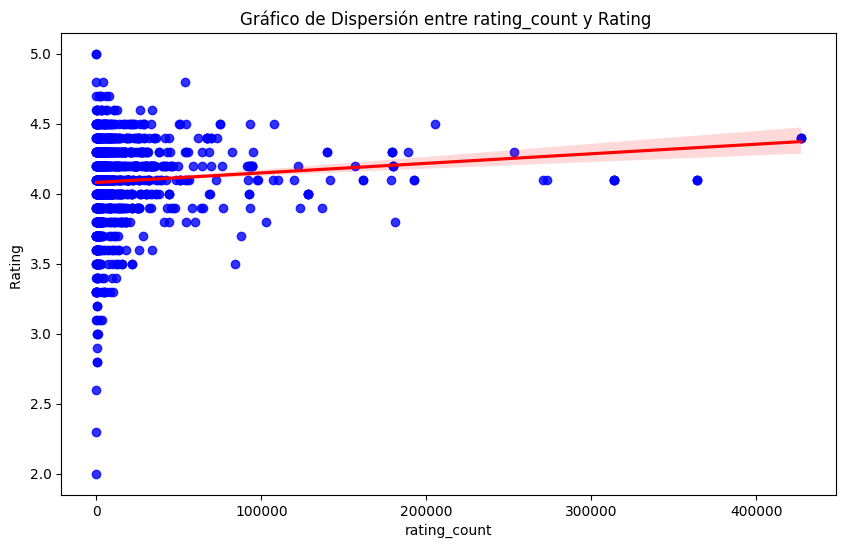

La correlación de Pearson entre 'rating' y 'rating_count' es: 0.09765125669109298


In [ ]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el gráfico de dispersión con la línea de tendencia
sns.regplot(x="rating_count", y="rating", data=df_consolidado, scatter_kws={"color": "blue"}, line_kws={'color': 'red'})

# Añadir etiquetas y título
plt.xlabel('rating_count')
plt.ylabel('Rating ')
plt.title('Gráfico de Dispersión entre rating_count y Rating ')

# Mostrar el gráfico
plt.show()

# Calcular la correlación de Pearson entre 'rating' y 'discounted_percentage'
correlacion_pearson = df_consolidado['rating'].corr(df_consolidado['rating_count'], method='pearson')

# Mostrar el resultado
print(f"La correlación de Pearson entre 'rating' y 'rating_count' es: {correlacion_pearson}")

In [ ]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            1339 non-null   object 
 1   product_name          1339 non-null   object 
 2   category              1339 non-null   object 
 3   main_category         1339 non-null   object 
 4   second_category       1339 non-null   object 
 5   other_categories      1331 non-null   object 
 6   discounted_price      1339 non-null   float64
 7   actual_price          1339 non-null   float64
 8   discount_percentage   1339 non-null   float64
 9   rating                1339 non-null   float64
 10  rating_count          1339 non-null   float64
 11  link_corregido_final  880 non-null    object 
 12  imagen_unica          879 non-null    object 
 13  img_general           879 non-null    object 
 14  product_link          880 non-null    object 
dtypes: float64(5), object

In [ ]:
# Crear un boxplot interactivo usando Plotly para last_month_salary
fig = px.box(df_consolidado, y='rating', points="all", title="Boxplot de actual_price")
fig.show()

In [ ]:
# Suponiendo que tu DataFrame se llama df_test

# Agrupar por categoría
cohorts = df_consolidado.groupby('main_category').agg({
    'discounted_price': ['mean', 'sum', 'count'],
    'actual_price': ['mean', 'sum', 'count'],
    'rating': ['mean', 'count'],
    'rating_count': ['mean', 'sum']
})

# Renombrar columnas para mayor claridad
cohorts.columns = ['_'.join(col) for col in cohorts.columns]

# Mostrar las estadísticas descriptivas por categoría
print(cohorts)


                       discounted_price_mean  discounted_price_sum  discounted_price_count  actual_price_mean  actual_price_sum  actual_price_count  rating_mean  rating_count  rating_count_mean  rating_count_sum
main_category                                                                                                                                                                                                      
Car&Motorbike                        2339.00               2339.00                       1            4000.00           4000.00                   1         3.80             1            1118.00           1118.00
Computers&Accessories                 951.37             354860.36                     373            1862.35         694656.62                 373         4.15           373           16984.39        6335177.00
Electronics                          6206.00            2985085.00                     481           10294.12        4951470.00                 481     

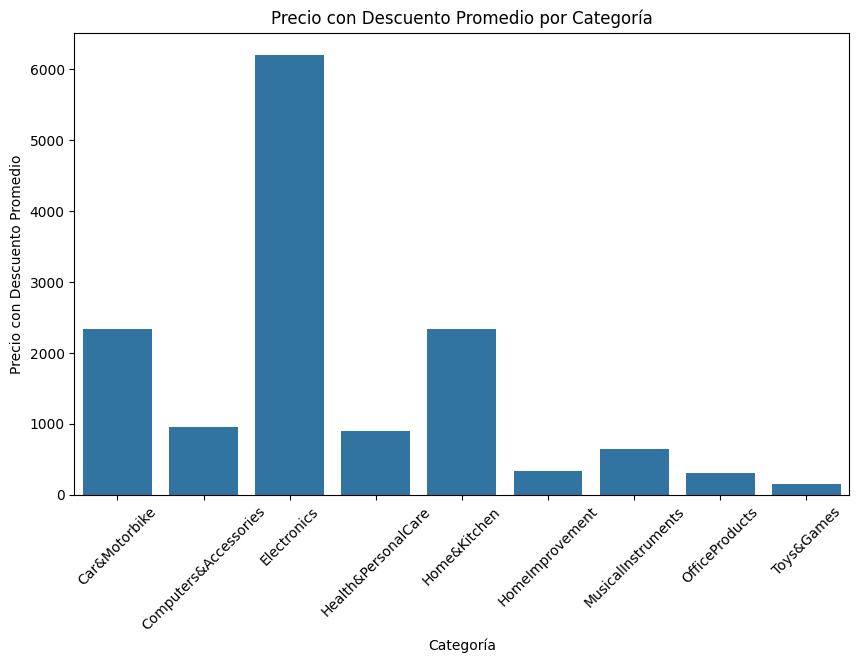

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cohorts.index, y=cohorts['discounted_price_mean'])
plt.title('Precio con Descuento Promedio por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Precio con Descuento Promedio')
plt.xticks(rotation=45)
plt.show()


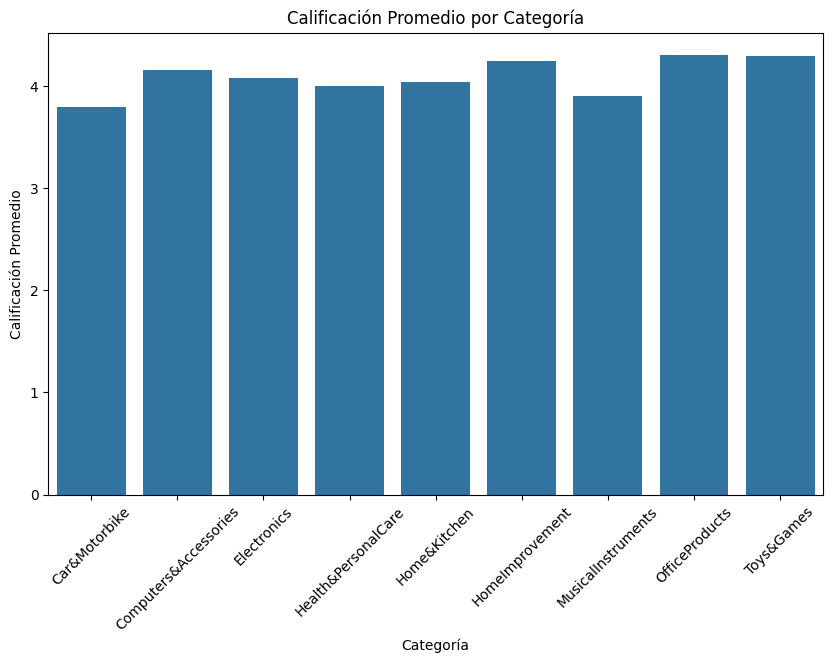

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cohorts.index, y=cohorts['rating_mean'])
plt.title('Calificación Promedio por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Calificación Promedio')
plt.xticks(rotation=45)
plt.show()


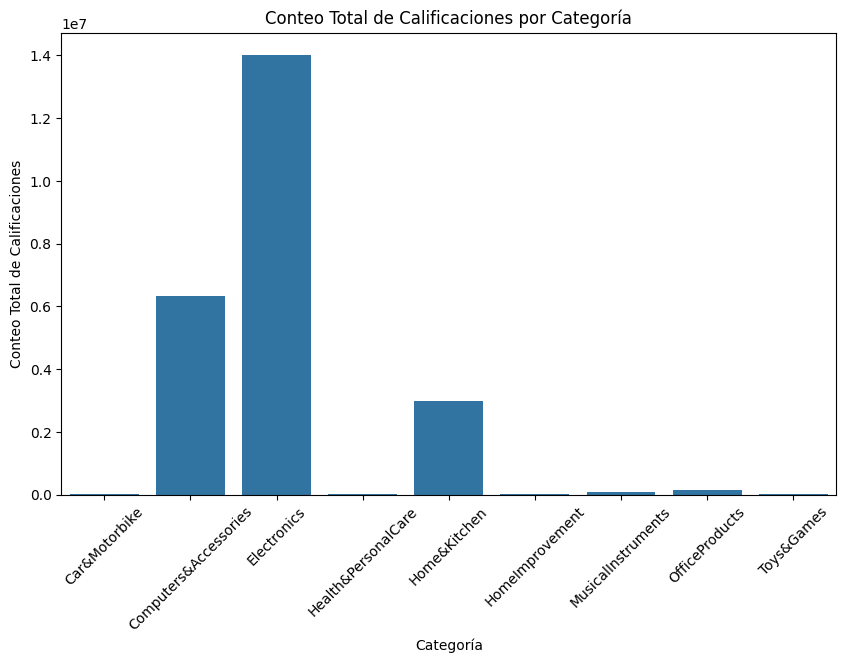

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cohorts.index, y=cohorts['rating_count_sum'])
plt.title('Conteo Total de Calificaciones por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Conteo Total de Calificaciones')
plt.xticks(rotation=45)
plt.show()


In [ ]:
########### Test de significancia

In [ ]:
##CODIGO PARA AUTENTICARSE CON GOOGLE
from google.colab import auth
auth.authenticate_user()

## CODIGO PARA VINCULARSE A BIGQUERY
from google.cloud import bigquery

# Configurar el cliente de BigQuery
client = bigquery.Client(project='amazon4-4')
# Definir la consulta para la vista
query = """
SELECT *
FROM `amazon4-4.dataset.consolidado_1`
"""
# Ejecutar la consulta
query_job = client.query(query)
results = query_job.result()

# Convertir los resultados a un DataFrame de pandas
df_test = results.to_dataframe()

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            1339 non-null   object 
 1   product_name          1339 non-null   object 
 2   category              1339 non-null   object 
 3   main_category         1339 non-null   object 
 4   second_category       1339 non-null   object 
 5   other_categories      1331 non-null   object 
 6   discounted_price      1339 non-null   float64
 7   actual_price          1339 non-null   float64
 8   discount_percentage   1339 non-null   float64
 9   rating                1339 non-null   float64
 10  rating_count          1339 non-null   float64
 11  link_corregido_final  880 non-null    object 
 12  imagen_unica          879 non-null    object 
 13  img_general           879 non-null    object 
 14  product_link          880 non-null    object 
dtypes: float64(5), object

In [ ]:
######### Test Manwhitney U

In [ ]:
######### Variables de Hipotesis 1
###¿Los productos con mayores descuentos obtienen mejores calificaciones?

from scipy.stats import mannwhitneyu

# Segmentar discount_percentage en 'alto' y 'bajo' según la mediana
mediana_descuento = df_test['discount_percentage'].median()
df_test['discount_segment'] = df_test['discount_percentage'].apply(lambda x: 'alto' if x > mediana_descuento else 'bajo')

# Crear dos grupos de rating
grupo_alto = df_test[df_test['discount_segment'] == 'alto']['rating']
grupo_bajo = df_test[df_test['discount_segment'] == 'bajo']['rating']

# Realizar el test de Mann-Whitney U
stat, p_value = mannwhitneyu(grupo_alto, grupo_bajo, alternative='two-sided')

# Mostrar resultados
print(f'Estadístico de prueba: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.")
else:
    print("No hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.")


Estadístico de prueba: 192458.5
Valor p: 6.966981501195077e-06
Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.


In [ ]:
######### Variables de Hipotesis 2
### ¿Los productos con más votaciones tienen mejores calificaciones?

# Segmentar rating_count en 'alto' y 'bajo' según la mediana
mediana_rating_count = df_test['rating_count'].median()
df_test['rating_count_segment'] = df_test['rating_count'].apply(lambda x: 'alto' if x > mediana_rating_count else 'bajo')

# Crear dos grupos de rating
grupo_alto = df_test[df_test['rating_count_segment'] == 'alto']['rating']
grupo_bajo = df_test[df_test['rating_count_segment'] == 'bajo']['rating']

# Realizar el test de Mann-Whitney U
stat, p_value = mannwhitneyu(grupo_alto, grupo_bajo, alternative='two-sided')

# Mostrar resultados
print(f'Estadístico de prueba: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.")
else:
    print("No hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.")


Estadístico de prueba: 267959.5
Valor p: 4.252434293759777e-10
Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating.


In [ ]:
######### Variables de Hipotesis 3
###  ¿Un mayor descuento está asociado con un mayor número de votaciones del producto?

# Segmentar discount_percentage en 'alto' y 'bajo' según la mediana
mediana_descuento = df_test['discount_percentage'].median()
df_test['discount_segment'] = df_test['discount_percentage'].apply(lambda x: 'alto' if x > mediana_descuento else 'bajo')

# Crear dos grupos de rating
grupo_alto = df_test[df_test['discount_segment'] == 'alto']['rating_count']
grupo_bajo = df_test[df_test['discount_segment'] == 'bajo']['rating_count']

# Realizar el test de Mann-Whitney U
stat, p_value = mannwhitneyu(grupo_alto, grupo_bajo, alternative='two-sided')

# Mostrar resultados
print(f'Estadístico de prueba: {stat}')
print(f'Valor p: {p_value}')

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating_count.")
else:
    print("No hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating_count.")


Estadístico de prueba: 189683.5
Valor p: 1.2158901599715377e-06
Hay una diferencia significativa entre los grupos 'alto' y 'bajo' en términos de rating_count.
